# A Look Into Crime In Seattle

### Introduction

As a student at the University of Washington, I often heard about how "sketchy" the area around campus was. Students regularly receive alerts concerning muggings, thefts, and other crimes that occur nearby. The Safeway store on Brooklyn Ave is even dubbed _Sketchway_ or _UnSafeway_. This inspired me to dig a little further into the issue. The following is a brief analysis of crime in Seattle with regard to both time and location. I hope you enjoy!

In [360]:
#Stuff I need
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

#Read the files
map_df = gpd.read_file("SPD_Beats_WGS84.shp")
df = pd.read_csv("Crime_Data.csv")

In [361]:
#Pick the useful columns
df = df[['Occurred Date', 'Occurred Time', 'Reported Date', 'Reported Time',
        'Primary Offense Description', 'Precinct', 'Beat', 'Neighborhood']]

#Switch to datetime dtype instead of object
df['Occurred Date'] = pd.to_datetime(df['Occurred Date'])
df['Reported Date'] = pd.to_datetime(df['Reported Date'])

#Just drop the nans
df = df.dropna(axis=0)

#Data is only complete from 2008 to 2018
df = df.loc[df['Occurred Date'] > '2008-01-01']
df = df.loc[df['Occurred Date'] < '2019-01-01']

### General Overview
After inspecting the data, I decided on a few key questions that I wanted to answer.

1. Which crimes are most commonly reported?
2. At which times of day and year do crimes occur most frequently?
3. Has crime gone up or down over time?
4. Which areas of Seattle are the most dangerous?

In the cells below, I will dive into each question individually - showing my code and process for how I answered each.


### 1. Which Crimes Are Most Common?
The first question is also the most basic: which crimes happen the most? There are 144 unique different types of crimes that the Seattle police sort reports into. As an example, vehicle thefts are categorized as VEH-THEFT-AUTO. Just to give you an idea of the specificity of these categories, there is a separate category called VEH-THEFT-MTRCYCLE for motorcycle thefts. I found the ten most common crimes and plotted them on the bar plot below. As you can see, car prowling is by far the most commonly reported crime - constituting about 25% of all crimes reported from 2008 to 2018. There are 503,614 total reported crimes, and 127,255 of those are car prowls. For the curious, 503,614 total crimes from 2008 to 2018 turns out to be an average of about 125 crimes reported every day! (More on crime frequency later).

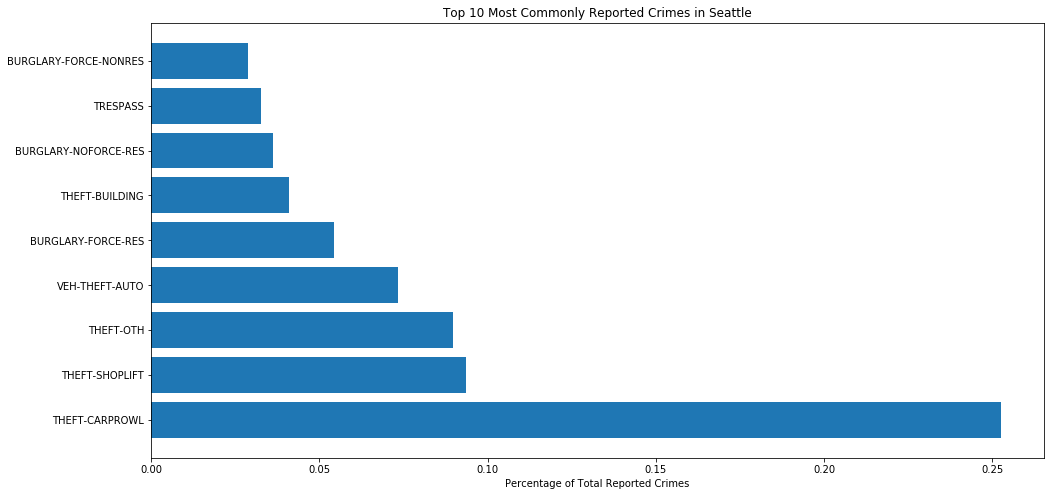

In [362]:
#Isolate just the crime descriptions column
crime_descs = df['Primary Offense Description']
num_crime_descs = crime_descs.nunique() #144 unique crime descriptions

#Find the top 10 most common crimes
num_indv_crimes = crime_descs.value_counts()

#Start organizing data so I can plot it
tot_crimes = num_indv_crimes.sum() #503614

x = num_indv_crimes[0:9].tolist()
x_pct = x/tot_crimes

#Plot
fig1, ax1 = plt.subplots(1, figsize = (16,8))
plt.barh(np.arange(len(x_pct)), x_pct)
plt.yticks(y_pos, num_indv_crimes.index[0:9])
plt.xlabel('Percentage of Total Reported Crimes')
plt.title('Top 10 Most Commonly Reported Crimes in Seattle')
fig1.savefig('top_10_crimes', dpi=300)

### 2. When Do Crimes Occur?
Next, I wanted to look at when crimes are most likely to occur. As you can see, occurrances are at the lowest at 5:00am, generally build until peaking at 6:00pm, then begin to generally decline again. In fact, crimes are approximately 5x more likely to happen at 6:00pm than they are at 5:00am. Another interesting feature is that crime occurrances drop off dramatically from 12:00am to 1:00am. As for the crimes per month graph, all months seem to be relatively equal. January and February have the highest and lowest crime counts, respectively, but based on how close they still are I doubt that there is much insight to be gleaned there.

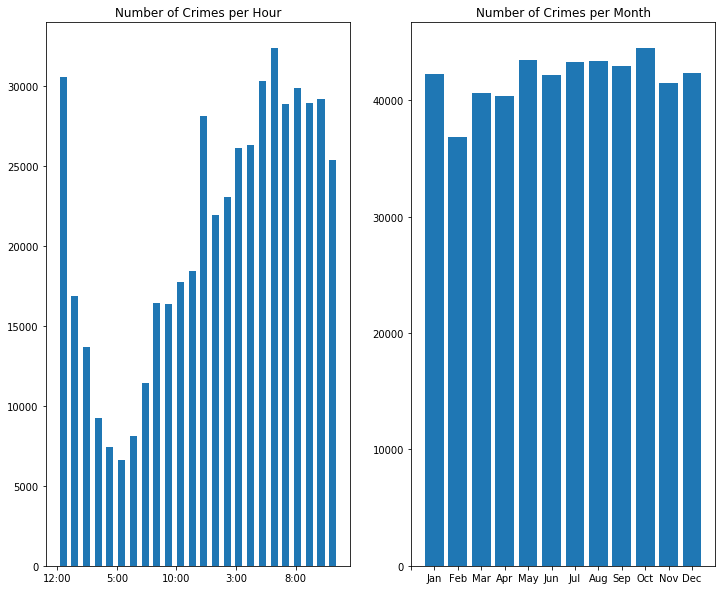

In [363]:
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12,10))

#Plot the crimes per hour
ax2.hist(df['Occurred Time'], bins=24, rwidth = 0.6)
ax2.set_title('Number of Crimes per Hour')
ax2.set_xticklabels(['', '12:00', '5:00', '10:00', '3:00', '8:00'])

#Plot the crimes per month
m = df.groupby(df['Occurred Date'].dt.month)
m = m.count()['Occurred Date'].tolist()
ax3.bar(np.arange(len(m)), m)
ax3.set_xticks([-1,0,1,2,3,4,5,6,7,8,9,10,11])
ax3.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.set_title('Number of Crimes per Month')

fig2.savefig('crimes_per_hour_year', dpi=300)

### 3. How Has Crime Frequency Changed?
Third, I investigated how the frequency of crime in Seattle has changed over time. Although we see that the trend appears to be an increasing number of crimes, we can also see that the per capita crime rate doesn't appear to be increasing or decreasing on the whole. Additionally, we see that per capita crime rate had a low point in 2012 and a high point in 2014. Unfortunately, I could only find Seattle population data for 2010-2017.

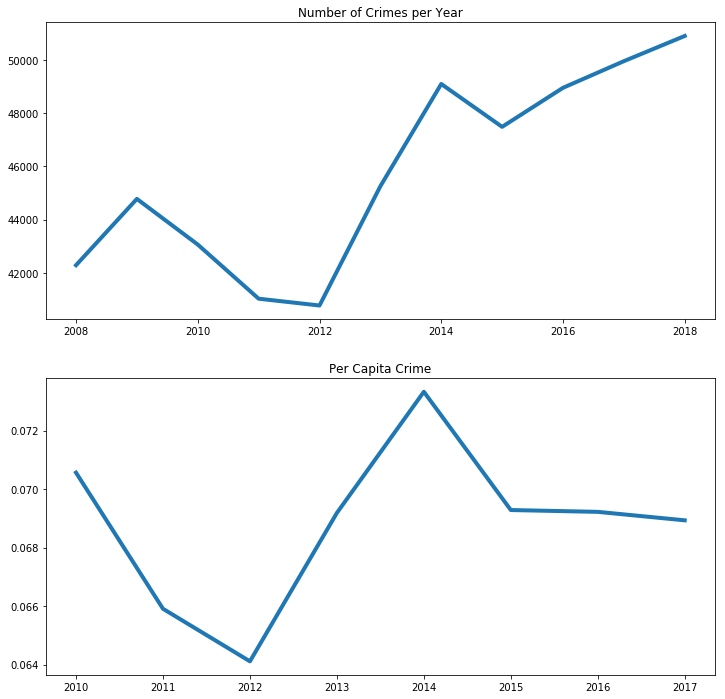

In [372]:
#Group by year and get the counts
yr = df.groupby(df['Occurred Date'].dt.year)
yr = yr.count()['Occurred Date']

#Create a series for population data and crime per capita data
pop = pd.Series([610333, 622532, 635974, 654176, 669641, 685447, 707255, 724745],
               index = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

per_cap = yr[2:-1]/pop

#Plot it
fig3, (ax4, ax5) = plt.subplots(2, 1, figsize = (12, 12))

ax4.plot(yr, linewidth=4.0)
ax4.set_title('Number of Crimes per Year')

ax5.plot(per_cap, linewidth=4.0)
ax5.set_title('Per Capita Crime')
fig3.savefig('crimes_over_time.png', dpi=300)

### 4. Which Areas are Most Dangerous?
To investigate my last question, I decided to define the most dangerous areas as simply the ones with the highest number of crimes. Each polygon on the map is one police beat. A beat is the area that is assigned to police officers when they go out on patrol. We can see that there are a large number of crimes around downtown, and also a large number in the area just north of the University of Washington campus. It looks like the U District has indeed earned its reputation for being sketchy! It's also ineresting to note which neighborhoods are safer in comparison - some have about half the number of crimes as the U District. Perhaps perspective Seattlites should consider moving to those areas if they're apprehensive about crime.

In [365]:
#Get a count of how many crimes occurred in each beat during the selected years
crimes_per_beat = df.groupby('Beat').count()

#Get rid of unnecessary columns and rename
crimes_per_beat = crimes_per_beat[['Occurred Time']]
crimes_per_beat.rename(columns = {'Occurred Time': 'Num Crimes'}, inplace=True)

#We only care about the main beats, which all have well over 500 crimes
crimes_per_beat = crimes_per_beat.loc[crimes_per_beat['Num Crimes'] > 50]

#Get rid of the "nan" beat
crimes_per_beat = crimes_per_beat.drop(crimes_per_beat.index[-1])

In [366]:
#merge the dataframes
merged = map_df.set_index('beat').join(crimes_per_beat)

#get rid of beat 99 - not sure what that is
merged = merged.drop(merged.index[0])

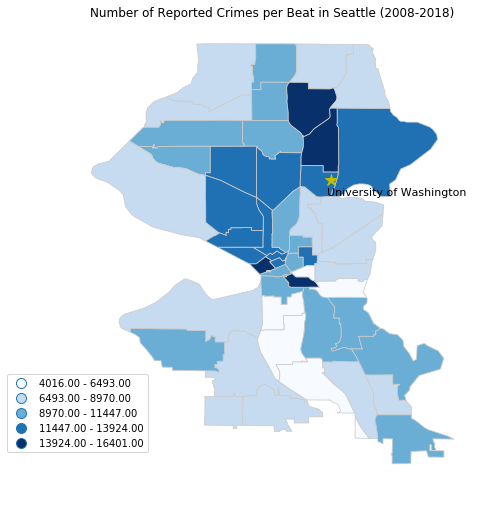

In [371]:
#start mapping!
fig4, ax6 = plt.subplots(1, figsize=(11, 8.5))

merged = merged.dropna()
merged.plot(column='Num Crimes', cmap='Blues', scheme='equal_interval', linewidth=0.8, ax=ax6, edgecolor='0.8', legend=True)
ax6.set_title('Number of Reported Crimes per Beat in Seattle (2008-2018)')
ax6.set_axis_off()
ax6.plot(-122.305, 47.657, 'y*', markersize=12)
ax6.annotate('University of Washington', (-122.305, 47.657), (-122.307, 47.648), fontsize=11)
ax6.get_legend().set_bbox_to_anchor((0.2, 0.25))

fig4.savefig("seattle_crime_map.png", dpi=300)

### Future Questions 
In the future, one question I would be really interested in researching is something along the lines of what actually causes crime. I could look at correlations between different things such as unemployment, education level, or population density and crime. Of course, correlation doesn't imply causation, but it might be possible to tease out some ideas. 
I could also go into more depth on the analysis I've done here. For example, I defined most dangerous to mean highest number of crimes, but other possible definitions could be highest crime per capita or highest number of deadly crimes. Similarly, I could slightly change my questions in the other sections. I wonder if there are more crimes on weekends than there are on weekdays? All are interesting furture projects for me.

Note: Crime and beat data are from data.seattle.gov
      Populaion data is from worldpopulationreview.com